In [61]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [62]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms

import torchinfo

import datasets
from datasets import DatasetDict

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [63]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP

    dataset = 'eurosat'

    coop_prompt_save_path = 's0_coop_eurosat.pt'

    #image_size: int = 224
    #num_workers: int = 4


    max_epochs: int = 80
    batch_size: int = 128

    prompt_len: int = 16
    k_per_class: int = 1

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 3e-4
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # Logs

    log_train_interval: int = 25
    log_val_interval: int = 25

    # Overfit sanity tiny subset
    #overfit_n_classes: int = 2
    #overfit_k_per_class: int = 8
    #overfit_epochs: int = 50


cfg = Config()
cfg


Config(max_epochs=80, batch_size=128, prompt_len=16, k_per_class=1, lr_base=1e-05, lr_prompt=0.0003, weight_decay=0.05, unfreeze_layers=(), log_train_interval=25, log_val_interval=25)

In [64]:
# --- Load model + preprocess ---
clip_model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)

torchinfo.summary(clip_model)

Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

In [65]:
#full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
#full_train_size = len(full_train_ds)
#val_size = int(full_train_size * 0.02)
#
#train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
#overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])
#
#train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
#val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)
#
#overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
#overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)
#
#classnames = full_train_ds.classes
#num_classes = len(classnames)
#
#print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")
#
#def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
#    batch = next(iter(dl))
#    images, labels = batch
#    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
#    for i in range(rows):
#        for j in range(cols):
#            idx = i*cols + j
#            if idx >= len(images):
#                break
#            img = images[idx].permute(1, 2, 0).cpu().numpy()
#            label = classnames[labels[idx]]
#            axs[i, j].imshow(img)
#            axs[i, j].set_title(label)
#            axs[i, j].axis('off')
#    plt.tight_layout()
#    plt.show()
#
#show_batch(val_loader, rows=2, cols=8)

In [66]:
full_ds = datasets.load_dataset(
    "jonathan-roberts1/EuroSAT",
    cache_dir="./hf_data",
)

full_train_ds = full_ds["train"]
full_ds = full_train_ds.train_test_split(test_size=0.1)

full_ds = DatasetDict({
    'train': full_ds['train'],
    'validation': full_ds['test']
})

train_ds = full_ds["train"]
val_ds = full_ds["validation"]
#test_ds = full_ds["test"]

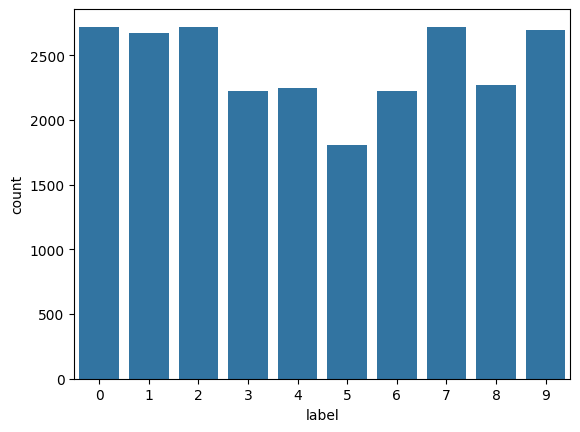

In [67]:
df = train_ds.to_pandas()

sns.countplot(df, x="label")
plt.show()

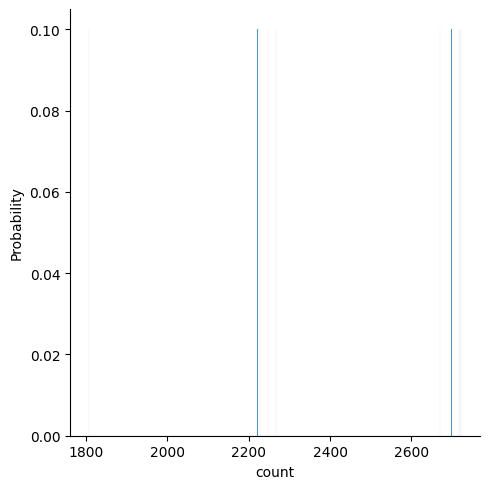

In [68]:
cls_counts = df["label"].value_counts().reset_index()
sns.displot(cls_counts, x="count", discrete=True, stat="probability")

In [69]:
def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

train_ds = train_ds.with_transform(transform)
val_ds   = val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    labels = torch.tensor([b["label"] for b in batch])       # [B]
    return images, labels

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

ClassLabel(names=['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake'])
Val dataset:   2700 images, 10 classes


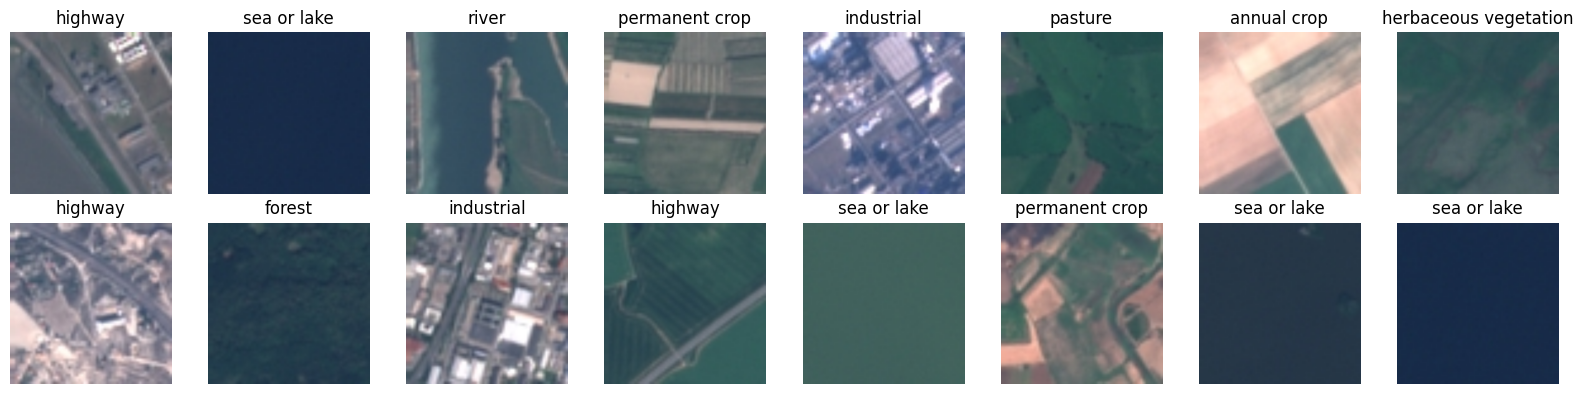

In [70]:
print(train_ds.features["label"])
label_feature = train_ds.features["label"]
classnames = label_feature.names
num_classes = label_feature.num_classes

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [71]:
from collections import defaultdict

def get_fewshot_dataloader(dl, k, *, label_col="label", seed=42):
    ds = dl.dataset
    #orig_tf = getattr(ds, "_transform", None)          # remember HF transform (if any)
    #base = ds.with_transform(None)                     # disable during index selection
    print(ds)

    # collect indices per class (HF: fast column access)
    idx_by_label = defaultdict(list)
    for i, batch in enumerate(ds):
        y = batch[label_col]
        idx_by_label[y].append(i)

    # choose up to k per class, then shuffle globally
    rng = random.Random(seed)
    selected = []
    for idxs in idx_by_label.values():
        rng.shuffle(idxs)
        selected.extend(idxs[:k])
    rng.shuffle(selected)

    subset = ds.select(selected)
    #if orig_tf is not None:
    #    subset = subset.with_transform(orig_tf)

    # rebuild a DataLoader reusing the original settings
    return DataLoader(
        subset,
        batch_size=dl.batch_size or 1,
        shuffle=False,                 # we already shuffled indices
        collate_fn=dl.collate_fn,
        num_workers=dl.num_workers,
        pin_memory=getattr(dl, "pin_memory", False),
        drop_last=getattr(dl, "drop_last", False),
        persistent_workers=getattr(dl, "persistent_workers", False),
    )

In [72]:
class HardcodedPrompt(nn.Module):
    def __init__(self, clip, classnames):
        super().__init__()
        #text_tower = getattr(clip, "text", clip)
        prompts = [f"a photo of a {c}" for c in classnames]
        ## Bad practice to use .to(device) in here, make sure it's a registered buffer
        text_tokens = tokenizer(prompts).to(device)
        text_features = clip.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward_text_features(self):
        return self.text_features

In [73]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, clip, hardcoded_prompt):
        super().__init__()
        self.clip = clip
        self.hardcoded_prompt = hardcoded_prompt

    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = self.hardcoded_prompt.forward_text_features()
            logits = 100.0 * image_features @ text_features.T
        return logits

In [74]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip, tokenizer, classnames, n_ctx=16, init_scale=0.02):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer
        self.classnames = classnames

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.register_buffer('class_token_ids', tokenizer(classnames)) # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.register_buffer('eot_indices', self.class_token_ids.argmax(dim=-1))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward_text_features(self, ctx_override=None):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]


        ctx = self.ctx if ctx_override is None else ctx_override
        # Learnable context repeated across classes
        ctx = ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]
        n_ctx = ctx.shape[0]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(C, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + n_ctx).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=eot.device), eot] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [75]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_prompt):
        super().__init__()
        self.clip = clip
        self.coop_prompt = coop_prompt
        self.clip.requires_grad_(False)
        #self.coop_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.coop_prompt.train()
        else:
          self.clip.eval()
          self.coop_prompt.eval()

    def forward(self, images):
        images = images.to(device)
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = self.coop_prompt.forward_text_features()
        logits = 100.0 * image_features @ text_features.T
        return logits

In [76]:
class MeanCoOpPrompt(nn.Module):
    def __init__(self, coop_prompts, which_require_grad=None):
        super().__init__()
        self.coop_prompts = nn.ModuleList(coop_prompts)

        if which_require_grad == None:
            which_require_grad = [True for _ in range(len(coop_prompts))]

        self.which_require_grad = which_require_grad

        for i, coop_prompt in enumerate(self.coop_prompts):
            coop_prompt.ctx.requires_grad_(self.which_require_grad[i])

    def train(self, mode=True):
        super().train(mode)
        if mode:
            for i, coop_prompt in enumerate(self.coop_prompts):
                coop_prompt.train(self.which_require_grad[i])
        else:
            for i, coop_prompt in enumerate(self.coop_prompts):
                coop_prompt.eval()

    def forward_text_features(self):
        ctxs = torch.stack([p.ctx for p in self.coop_prompts], dim=0)
        ctx_mean = ctxs.mean(dim=0)

        base = self.coop_prompts[0]
        return base.forward_text_features(ctx_override=ctx_mean)


In [77]:
def accuracy(logits, labels):
    preds = logits.argmax(dim=-1)
    correct = (preds == labels).float().mean().item()
    return correct

In [78]:
@torch.no_grad()
def evaluate_classifier(model, test_loader, loss_fn, device, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  for images, labels in iterator:
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    logits = model(images)
    loss = loss_fn(logits, labels)

    bs = labels.size(0)
    loss_sum += loss.item() * bs
    preds = logits.argmax(dim=1)
    correct += (preds == labels).sum().item()
    count += bs

    if pbar:
      acc = (correct / max(1, count)) * 100.0
      iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

  avg_loss = loss_sum / max(1, count)
  avg_acc = correct / max(1, count)
  return avg_loss, avg_acc

def train(
    model, train_loader, val_loader, device="cpu",
    epochs=5, batch_size=256, lr=5e-3, log_train_interval=25, log_val_interval=None
):
    model.to(device)

    print(model.coop_prompt.parameters())

    trainable_params = (p for p in model.parameters() if p.requires_grad)
    optimizer = torch.optim.AdamW(trainable_params, lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_time': [], 'val_time': []
    }

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = evaluate_classifier(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val_time'].append(t)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)
            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            history['train_time'].append(t)
            history['train_loss'].append(loss.item())
            history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

            if log_val_interval and t % log_val_interval == 0:
                val_loss, val_acc = evaluate_classifier(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_time'].append(t)
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )


        avg_train_loss = np.mean(history['train_loss'][-len(train_loader):])
        avg_train_acc = np.mean(history['train_acc'][-len(train_loader):])
        avg_val_loss = history['val_loss'][-1]
        avg_val_acc = history['val_acc'][-1]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    if t > 0:
        val_loss, val_acc = evaluate_classifier(
              model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_time'].append(t)

    return history

In [79]:
clip_model.to(device)

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): FastVit(
      (stem): Sequential(
        (0): MobileOneBlock(
          (se): Identity()
          (conv_kxk): ModuleList(
            (0): ConvNormAct(
              (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (bn): BatchNormAct2d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
            )
          )
          (conv_scale): ConvNormAct(
            (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
          )
          (act): GELU(approximate='none')
        )
        (1): MobileOneBlock(
          (se): Identity()
          (conv_kxk): ModuleList

In [80]:
if cfg.k_per_class == 0:

    hardcoded_prompt = HardcodedPrompt(
        clip=clip_model,
        classnames=classnames
    )

    zeroshot_clip = ZeroShotClassifier(
        clip=clip_model,
        hardcoded_prompt=hardcoded_prompt
    ).to(device)


    loss, acc = evaluate_classifier(
        model=zeroshot_clip,
        test_loader=val_loader,
        device=device,
        loss_fn=nn.CrossEntropyLoss(),
        desc="Testing Zeroshot Clip on full val",
        pbar=True
    )
    print(f"Accuracy for zeroshot: {acc}")

In [81]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    ax = axes[0]
    ax.plot(history['train_time'], history['train_loss'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_loss' in history and len(history['val_time']) and len(history['val_loss']):
        ax.plot(history['val_time'], history['val_loss'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Loss'); ax.set_title('Loss'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    ax = axes[1]
    if 'train_acc' in history and len(history['train_acc']):
        ax.plot(history['train_time'], history['train_acc'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_acc' in history and len(history['val_time']) and len(history['val_acc']):
        ax.plot(history['val_time'], history['val_acc'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Accuracy'); ax.set_title('Accuracy'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    plt.show()

In [ ]:
train_k_loader = get_fewshot_dataloader(train_loader, k=cfg.k_per_class)

Dataset({
    features: ['image', 'label'],
    num_rows: 24300
})


In [ ]:
coop_k_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
)

coopclip_k_model = CoOpClip(
    clip=clip_model,
    coop_prompt=coop_k_prompt,
).to(device)

In [ ]:
history = train(
    model=coopclip_k_model,
    train_loader=train_k_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=cfg.log_train_interval,
    log_val_interval=cfg.log_val_interval,
)

In [ ]:
plot_history(history)

In [ ]:
import torch, hashlib, json

def save_coop_prompt(coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str, classnames: list, n_ctx: int):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    payload = {
        "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
        "meta": {
            "model_name": model_name,
            "pretrained": pretrained,
            "n_ctx": int(n_ctx),
            "classnames": list(classnames),
            # quick fingerprint to catch class order changes
            "classnames_sha1": hashlib.sha1(
                json.dumps(list(classnames), ensure_ascii=False).encode("utf-8")
            ).hexdigest(),
        }
    }
    torch.save(payload, path)


In [ ]:
save_coop_prompt(coopclip_k_model.coop_prompt, cfg.coop_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained,
                 classnames=classnames, n_ctx=cfg.prompt_len)

In [ ]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  ctx = payload["ctx"]
  n_ctx = payload["meta"]["n_ctx"]
  classnames = payload["meta"]["classnames"]
  model_name = payload["meta"]["model_name"]
  if cfg.model_name != model_name:
    raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.modelname: '{cfg.model_name}'")
  coop_prompt = CoOpPrompt(clip, tokenizer, classnames, n_ctx)
  with torch.no_grad():
    coop_prompt.ctx.copy_(ctx)

  return coop_prompt

In [ ]:
loaded_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_prompt_save_path)

In [ ]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=loaded_prompt,
).to(device)

loss, acc = evaluate_classifier(
    model=loaded_coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for loaded model: {acc}")

### Some more metrics

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, classnames=None):
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, leave=False, desc='cm'):
            p = model(x.to(device)).argmax(dim=1).cpu()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(p.tolist())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classnames)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, include_values=False, xticks_rotation=90, cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout(); plt.show()

plot_confusion_matrix(coopclip_k_model)

### Test on real image

In [ ]:
from PIL import Image
image = Image.open("rose_flower.jpg")
plt.imshow(image)
logits = coopclip_model(preprocess(image).unsqueeze(0))
pred = logits.argmax(1)
pred_class = classnames[pred]
print(f"The image is a {pred_class}")